In [1]:
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np

import math

%matplotlib notebook 

import matplotlib.pyplot as plt
%matplotlib notebook


from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

In [32]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node ec1b642f-b5f0-40aa-987a-43122cc6e305

# Toolbox 

In [3]:
#This function converts pixels in cm


def pix_to_cm(point_rouge1, point_rouge2, point):
    
    dist_pix = np.sqrt((point_rouge2[0] - point_rouge1[0])**2 + (point_rouge2[1]- point_rouge1[1])**2)
    point = np.array(point)*(5/dist_pix)
    
    return point

# A. Image analysis

## Obstacle detection

In [4]:
capture = cv2.VideoCapture(0) 

In [5]:
while True:
    ret, frame = capture.read()
    cv2.imshow('video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('capture.jpg', frame)
        break
capture.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>


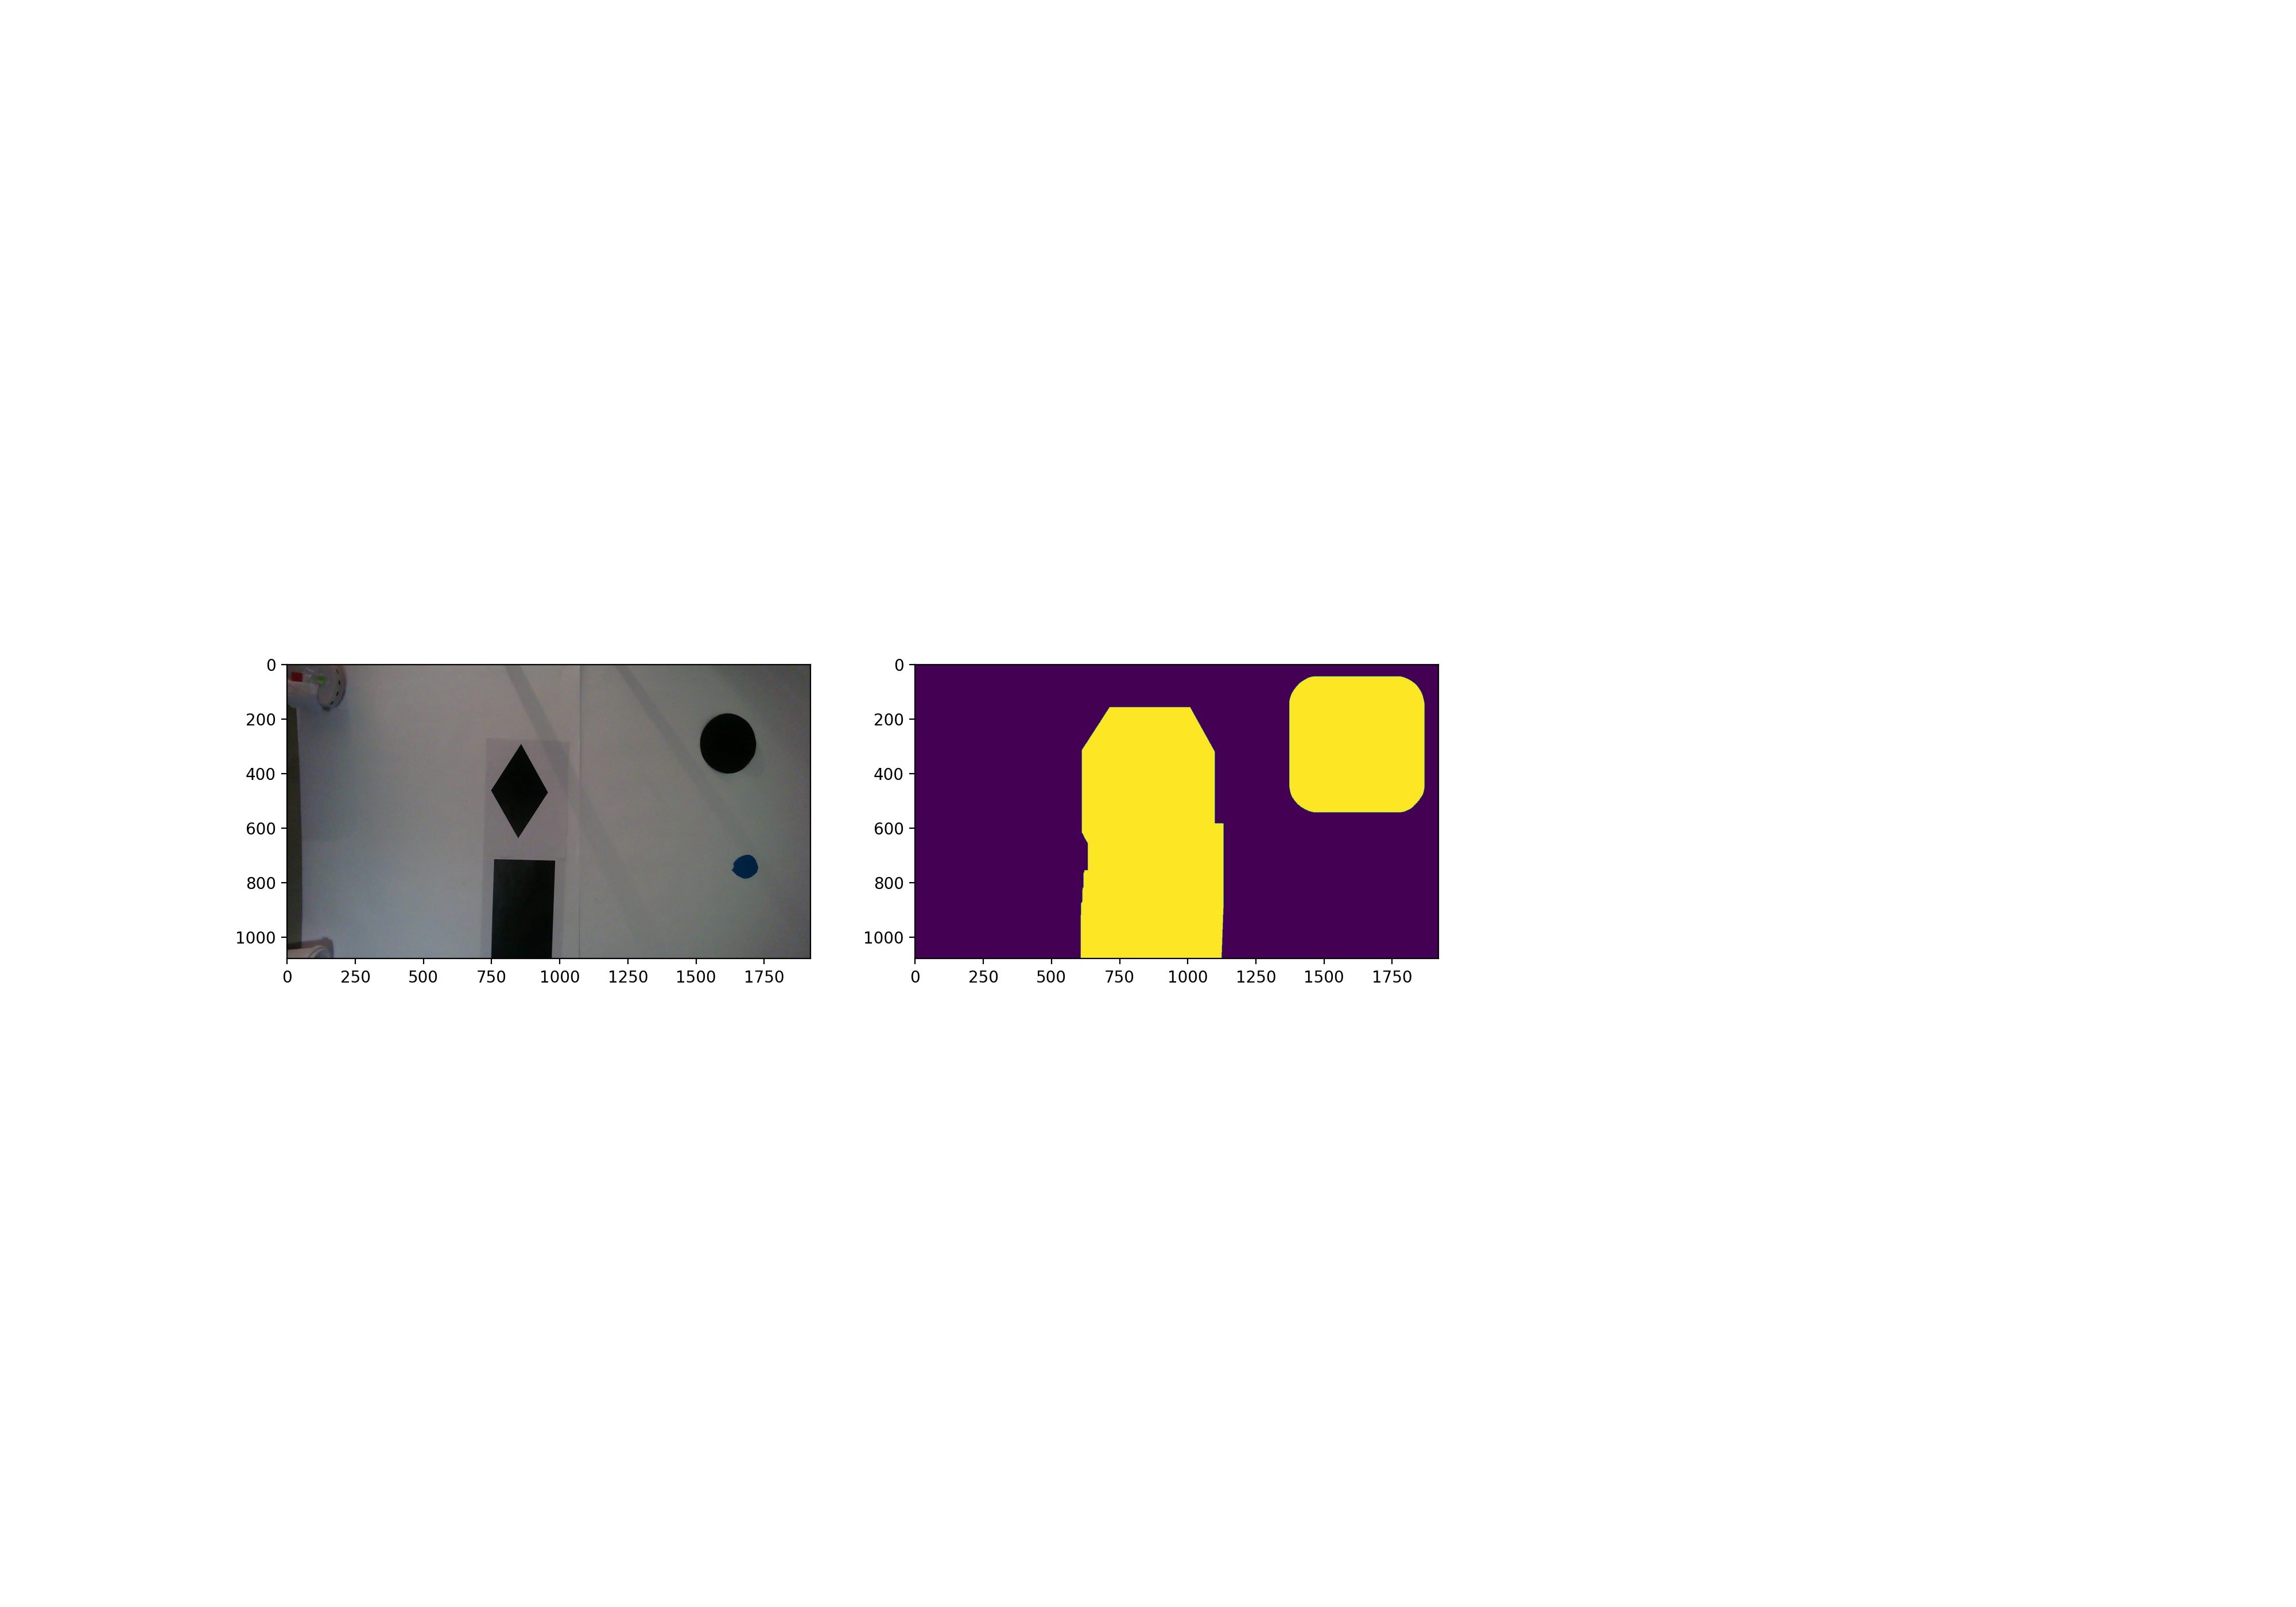

In [6]:
out=cv2.imread('capture.jpg')

# Mask for black obstacles 
lower_dark = np.array([0,0,0])
higher_dark = np.array([25,25,25])
mask=cv2.inRange(out,lower_dark,higher_dark)
mask=cv2.GaussianBlur(mask,(5,55),0)
ret, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)

result=cv2.bitwise_and(out,out,mask=mask)
kernel = np.ones((50,50),np.uint8)
fin = cv2.dilate(mask, kernel, iterations = 6)
fig = plt.figure(figsize=(20, 14))
columns=3
fig.add_subplot(1, columns, 1)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
fig.add_subplot(1, columns, 2)

plt.imshow(fin)

## Detection of the starting position and the goal

In [7]:
cap = cv2.VideoCapture(0)

In [8]:
# Initialisation

low_green = np.array([40, 55, 70]) 
high_green = np.array([102, 255, 255]) 

low_blue = np.array([96, 100, 50])
high_blue = np.array([126, 255, 255])

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160,100,20])
upper2 = np.array([179,255,255])
 
#Initial position of the green and red dot on the Thymio
pt_thymio_red0= np.zeros(2,) 
pt_thymio_green0 = np.zeros(2,) 

In [9]:
while True:
    _, frame = cap.read()
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
#1. Find the position of the Thymio
    # RED DOT

    lower_mask = cv2.inRange(hsv_frame, lower1, upper1)
    upper_mask = cv2.inRange(hsv_frame, lower2, upper2)
    red_mask = lower_mask + upper_mask;
    red = cv2.bitwise_and(frame, frame, mask=red_mask)
    contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_red = int(M["m10"]/ M["m00"])
            cy_red = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_red,cy_red),7,(255,255,255),-1)
            pt_thymio_red0 =  [cx_red, cy_red]
                    

    # GREEN DOT:

    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    green = cv2.bitwise_and(frame, frame, mask=green_mask)
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_green = int(M["m10"]/ M["m00"])
            cy_green = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_green,cy_green),7,(255,255,255),-1)
            pt_thymio_green0 =  [cx_green, cy_green]
            
              
#2. Find the goal
    # Track blue:
    
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    blue = cv2.bitwise_and(frame, frame, mask=blue_mask)
    contours, hierarchy = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(255,0,0), 3)
            M = cv2.moments(c)
            cxb = int(M["m10"]/ M["m00"])
            cyb = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cxb,cyb),7,(255,255,255),-1)
            goal_pix = [cxb, cyb]
        
    cv2.imshow("result",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(goal_pix)
        break
    

[1689, 742]


In [10]:
# Initial position of the Thymio / starting point
start_pix = [round((pt_thymio_green0[0] + pt_thymio_red0[0])/2), round((pt_thymio_green0[1] + pt_thymio_red0[1])/2)]
print(start_pix)

[216, 792]


In [11]:
#Rescale of the coordinates:
xgoal = round(goal_pix[0]/30)
ygoal = round(goal_pix[1]/30)

xstart = round(start_pix[0]/30)
ystart = round(start_pix[1]/30)

goal = (ygoal,xgoal)
start = (ystart,xstart)


# Global map:  A* program

In [12]:
dim = (64,36) #(64,36)

mask_noir = cv2.resize(fin, dim, interpolation = cv2.INTER_AREA)
max_valx = 36
max_valy = 64

data = np.array(mask_noir) #hough_maxima


limit = 250
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

In [13]:
def create_empty_plot(max_valx, max_valy):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticksx = np.arange(0, max_valx+1, 5)
    minor_ticksx = np.arange(0, max_valx+1, 1)
    
    major_ticksy = np.arange(0, max_valy+1, 5)
    minor_ticksy = np.arange(0, max_valy+1, 1)
    
    ax.set_xticks(major_ticksx)
    ax.set_xticks(minor_ticksx, minor=True)
    ax.set_yticks(major_ticksy)
    ax.set_yticks(minor_ticksy, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_valy])
    ax.set_xlim([-1,max_valx])
    ax.grid(True)
    
    return fig, ax

In [14]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [15]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():#COOOL
        #Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) #j'assigne à la position 0 à chaque fois.
        current=cameFrom[current]
    return total_path


def A_Star(start, goal, h, coords, hough_maxima, movement_type="8N", max_valy = max_valy):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node, tuple (x, y)
    :param goal_m: goal node, tuple (x, y)
    :param occupancy_grid: numpy array containing the map with the obstacles. At each position, 
                           you either have the number 1 (occupied) or 0 (free)
    :param movement: string, select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_valy, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]: #je pense = 1 si  obstacle
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    
    # Here we initialise the variables, feel free to print them or use the variable info function if it is not
    # what they contain or how to access the different elements
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    # Note that this is an addition w.r.t. the wikipedia pseudocode
    # It contains the list of variables that have already been visited 
    # in order to visualise them in the plots
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict() #camefrom le (x,y) sur le chemin optimal juste avant le node n = (currentx, currenty)

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))])) #il donne la valeur infini à chaque coordonnées
    fScore[start] = h[start] #ce h il vaut combien => on l'a calculé au départ
#range creer tableau de longueur len(coords)
    
    # while there are still nodes to visit (hint : change the while condition)

    while openSet != []:
        
            
        min = np.inf
        for p in openSet:
            if fScore[p] < min: #ici je vais reach for celui qui a le plus petit fScore et donc hScore
                min = fScore[p] 
                current = p
                
        #np.delete(openSet, current)
        #np.append(ClosedSet, current)
        
        openSet.remove(current)
        closedSet.append(current)
    
        #If the goal is reached, reconstruct and return the obtained path
        
        if current == goal: #ecriture vectorisé
            return reconstruct_path(cameFrom,current), closedSet
        

        # If the goal was not reached, for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] <0) or (neighbor[1] <0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0],neighbor[1]] == 1) or (neighbor in closedSet):
                continue
                
            # compute the cost to reach the node through the given path
            
            tentative_gScore = gScore[current] + deltacost
            
            
            # Add the neighbor list of nodes who's neighbors need to be visited
            if neighbor not in openSet:
                openSet.append(neighbor)
                #il faudrait que je remove de openset mon current nn?
            
            
            # If the computed cost if the best one for that node, then update the costs and 
            # node from which it came
            if tentative_gScore < gScore[neighbor]: #gScore[neighbor] a une valeur infinie
 
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current #j'ai l'impression que tout les neighbors de current seront dans camfrom hors on veut ceux qui on la plus faible f value
                gScore[neighbor] = tentative_gScore 
                fScore[neighbor] = gScore[neighbor] + h[neighbor]  #ici je compute le fscore pour tout les neighbors et plus loin je vais chercher le fscore plus petit qui va devenir current
                
                

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet                                                  

In [16]:
# List of all coordinates in the grid
x,y = np.mgrid[0:occupancy_grid.shape[0]:1, 0:occupancy_grid.shape[1]:1] 
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1) 
h = dict(zip(coords, h)) # cool

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")


# Creating checkpoints
checkpoint = []
direction = []
for x in range(1,len(path)):
    v = np.array(path[x]) - np.array(path[x-1])
    direction.append(v)

    
for x in range(1,len(path)-1):
    if ((direction[x-1][0] != direction[x][0]) | (direction[x-1][1] != direction[x][1])):
               checkpoint.append(path[x])

checkpoint.append(goal)
            
checkpoint_2 = np.array(checkpoint).reshape(-1, 2).transpose()

path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()


<IPython.core.display.Javascript object>


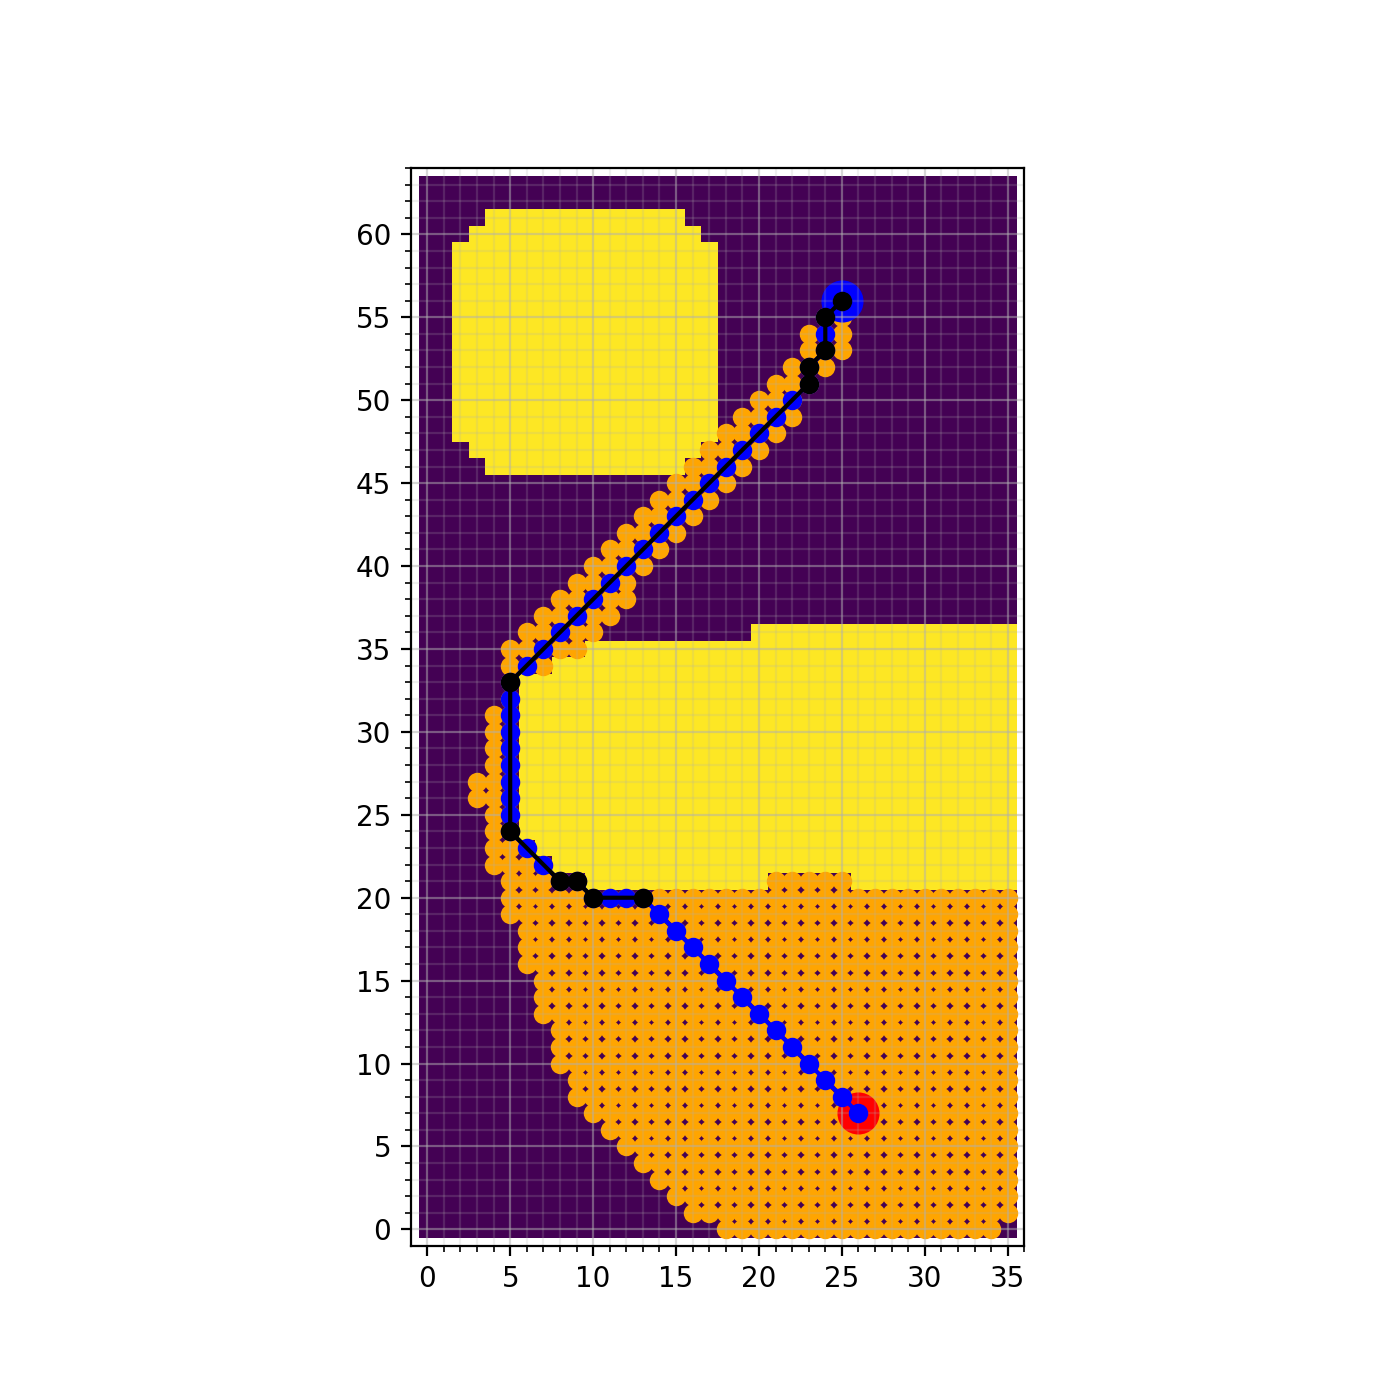

In [17]:
# Displaying the map
# Blue cicle: the goal 
# Red cicle: the starting point / inital position of the Thymio
# Blue dot: path generated by A* algorithm 
# Black dot: checkpoints

fig_astar, ax_astar = create_empty_plot(36, 64)

ax_astar.imshow(occupancy_grid.transpose(), origin='upper')
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.plot(checkpoint_2[0], checkpoint_2[1], marker="o", color = 'black');
ax_astar.scatter(start[0], start[1], marker="o", color = 'red', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'blue', s=200);

In [18]:
# Smoothing the path

#----
# Initialisation

# Non rescaled checkpoints (used to plot the new trajectory in the next cell)
new_checkpoint_2_x = checkpoint_2[0]
new_checkpoint_2_y = checkpoint_2[0]

#rescaling the coordinates of the checkpoints
upsized_checkpoint =  [i * 30 for i in checkpoint_2] 

# Converting the checkpoints in cm
checkpoint_cm = pix_to_cm(pt_thymio_red0, pt_thymio_green0,upsized_checkpoint)

x = checkpoint_cm[0]
y = checkpoint_cm[1]


# ------
# We compute the distance between two consecutive checkpoints and erase one 
# if the distance is smaller than 5 cm

var = [] #contains the indexes of the checkpoints we want to erase

for j in range(0, len(checkpoint_cm[0])-2):
    dist_current = np.sqrt((checkpoint_cm[0][j+1] - checkpoint_cm[0][j])**2 + (checkpoint_cm[1][j+1] - checkpoint_cm[1][j])**2)
    if dist_current < 5:
        var.append(j+1)   
                
# ----
# Results

new_checkpoint_x_cm = np.delete(x, var)
new_checkpoint_y_cm = np.delete(y, var)

new_checkpoint_x = np.delete(upsized_checkpoint[0], var)
new_checkpoint_y = np.delete(upsized_checkpoint[1], var)

new_checkpoint_2_x=np.delete(checkpoint_2[0], var)
new_checkpoint_2_y=np.delete(checkpoint_2[1], var)


<IPython.core.display.Javascript object>


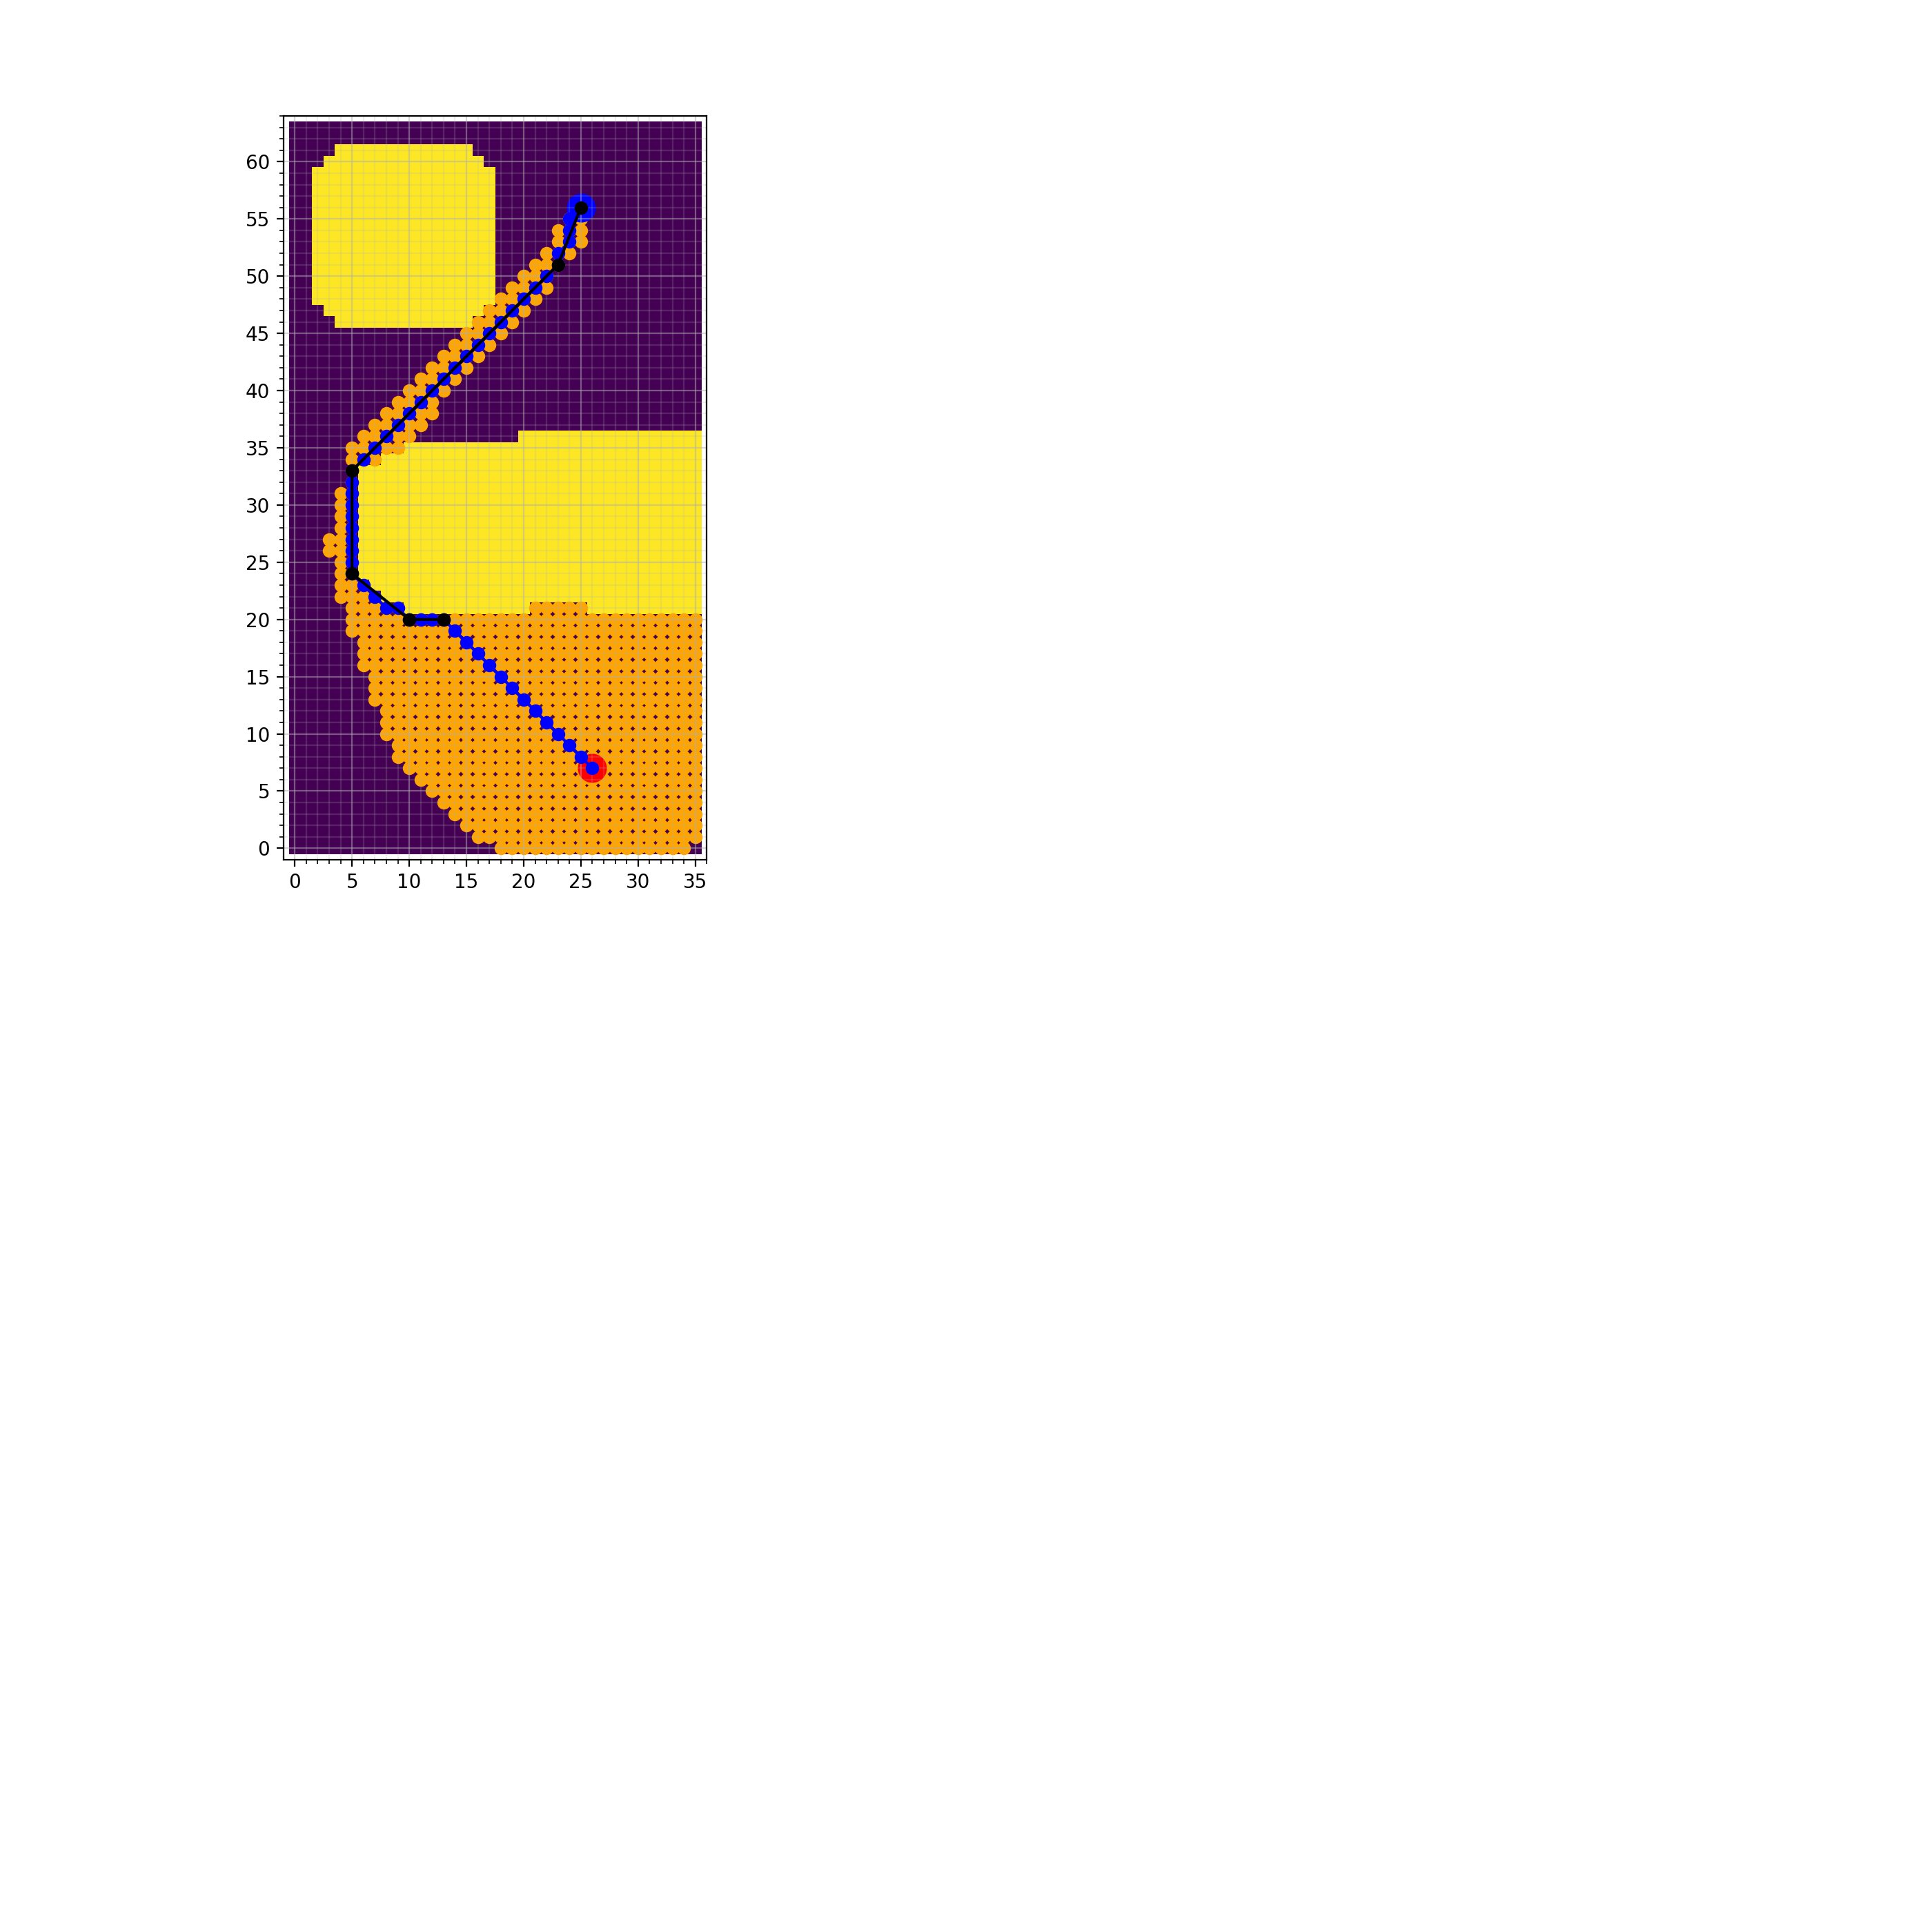

In [19]:
# Displaying the map
# Blue cicle: the goal 
# Red cicle: the starting point / inital position of the Thymio
# Blue dot: path generated by A* algorithm 
# Black dot: checkpoints
fig_astar, ax_astar = create_empty_plot(36, 64)

ax_astar.imshow(occupancy_grid.transpose(), origin='upper')
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.plot(new_checkpoint_2_x, new_checkpoint_2_y, marker="o", color = 'black');
ax_astar.scatter(start[0], start[1], marker="o", color = 'red', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'blue', s=200);

# Global motion control: proportional controllers

In [20]:
def controller(Xr, Yr, theta_r, Xt, Yt):
    Ul = 0
    Ur = 0
    marge_s= 40
    marge_t = 5   
    
    delta_Xref = Xt - Xr
    delta_Yref = Yt - Yr
    
    if delta_Xref != 0:
        # phi: the orientation we want to reach
        phi = round( np.rad2deg(np.arctan2(delta_Yref, delta_Xref)))
        
        # delta_phi: by how much the controller has to turn to reach the desired position
        delta_phi = (phi - theta_r)
        
    if delta_Xref == 0:
        delta_phi = 90 - theta_r
        phi = 90
    
    Ks = 0.3 
    Kt = 1.7
    
    # Angular error
    Et = round(delta_phi)
    
    if abs(Et)< marge_t:
        Et = 0
        
        
    # Position error
    Es = round(np.sqrt(delta_Xref**2 + delta_Yref**2 ) + np.cos(delta_phi))
    
    if abs(Es)< marge_s:
        Es = 0
        Et = 0
    
    #Proportional controllers 
    Vs = Ks*Es
    Vt = Kt*Et
    
    Ul = 90+round(Vs + Vt) #delta_phi / Et > 0 => Vt>0: on tourne à droite 
    Ur = 90+round(Vs - Vt)
    
    if Ul > 350:
        Ul = 350
        
    if Ur > 350:
        Ur = 350
        
    if Ul < -350:
        Ul = -350
    
    if Ur < -350:
        Ur = -350
    
    return Ul, Ur, Es, Et, phi

In [21]:
def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

# Kalman filter

In [22]:
def prediction(State_est_t_1,P_t_1,Q_t,left_speed,right_speed, temps_ecoule):
    k_v = 1
    k_d= 1
    r=2*k_d
    l=9.5*k_d
    State_est_t=State_est_t_1
    State_est_t_1[2]=np.deg2rad(State_est_t_1[2])
    
    
    A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    B= np.array([[(r/2)*temps_ecoule*np.cos(State_est_t_1[2]),(r/2)*temps_ecoule*np.cos(State_est_t_1[2])], 
                 [(r/2)*temps_ecoule*np.sin(State_est_t_1[2]),(r/2)*temps_ecoule*np.sin(State_est_t_1[2])], 
                 [r*temps_ecoule/l, r*temps_ecoule/(-l)]])
    
    u=[left_speed*k_v, right_speed*k_v]
    
    State_est_t=np.dot(A,State_est_t_1)+np.dot(B,u)    
    P_t_1 = np.dot(np.dot(A,P_t_1),A.T) + Q_t
    
    State_est_t[2]=np.rad2deg(State_est_t[2])

    return State_est_t,P_t_1


def update(State_est_t,P_t,Z_t,R_t, MaskAvailable, points, angle):
    H=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) #matrice d'observation
    
    S = np.dot(np.dot(H,P_t),H.T) + R_t
    
    if MaskAvailable:
        K = np.dot(np.dot(P_t,H.T),np.linalg.inv(S))
    else:
        K=0
    
    y = Z_t - np.dot(H,State_est_t)
   
    State_t = State_est_t + np.dot(K,y)
    
    I = np.eye(3)
    P_t = np.dot((I - np.dot(K,H)),P_t)
        
    return State_t,P_t

# Overall code

In [23]:
capt = cv2.VideoCapture(0) 

In [41]:
# Initialization:

# Parameter of the controller:
Ul= 0 
Ur= 0
Es= 0 
Et=0
phi=0
marge_s = 40
marge_t = 5
current = 0
Xt = new_checkpoint_y
Yt = new_checkpoint_x

#-----
# Parameters for the Kalman filter
State_est_t=[0, 0, 0] 
Q_t = np.diag([0.0004, 0.0615, 0.0004])
R_t=np.diag([0.0025, 0.0615, 0])
angle_deg=0
points=[[0], [0], [0]]
P_t = np.diag([1000.0, 1000.0, 1000.0])
speedconv=0.0435
temps_ecoule=0.01
Z_t=[0,0,0]
j=0
State_t=[0,0,0]
P_t=np.diag([1000,1000,1000])
prev_state = [[0,0,0] for i in range(0, 50)]

#-----
# Parameters for the local navigation 
speedGain = 2      # gain used with ground gradient
obstThrH = 20      # high obstacle threshold to switch state 0->1
obstSpeedGain = 10  # /100 (actual gain: 5/100=0.05)
state = 0        # 0=follow the trajectory, 1=obstacle avoidance
obst = [0,0]       # measurements from left and right prox sensors
tourne_g = 0
prox_horizontal = [0,0,0,0,0,0,0]

In [42]:
# Motion of the Thymio

while True:
    _, frame = capt.read()
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Dislay the goal 
    cv2.circle(frame,(goal_pix[0],goal_pix[1]),7,(255,255,255),-1)
    
    # Display the checkpoints:
    for i in range(len(new_checkpoint_x)):
        cv2.circle(frame,(new_checkpoint_y[i],new_checkpoint_x[i]),5,(0,255,255),-1)
        #cv2.putText(frame, str(new_checkpoint_y[i]), ((new_checkpoint_y[i]+20,new_checkpoint_x[i])), 1,1, (0,255,255))
        #cv2.putText(frame, str(new_checkpoint_x[i]), ((new_checkpoint_y[i]+80,new_checkpoint_x[i])), 1,1, (0,255,255))
        
    
#1. Position in real time of the Thymio
    # Track red dot
    lower_mask = cv2.inRange(hsv_frame, lower1, upper1)
    upper_mask = cv2.inRange(hsv_frame, lower2, upper2)
    red_mask = lower_mask + upper_mask;
    red = cv2.bitwise_and(result, result, mask=red_mask)
    contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_red_rt = int(M["m10"]/ M["m00"])
            cy_red_rt = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_red_rt,cy_red_rt),7,(0,0,255),-1)
            pt_thymio_red_rt =  [cx_red_rt, cy_red_rt]
    
    # Track green dot:
    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    green = cv2.bitwise_and(frame, frame, mask=green_mask)
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_green_rt = int(M["m10"]/ M["m00"])
            cy_green_rt = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_green_rt,cy_green_rt),7,(0,255,0),-1)
            pt_thymio_green_rt =  [cx_green_rt, cy_green_rt]
    
    # Position of the Thymio
    position_thymio_rt = [round((pt_thymio_green_rt[0] + pt_thymio_red_rt[0])/2), round((pt_thymio_green_rt[1] + pt_thymio_red_rt[1])/2)]                  
    
    cv2.circle(frame,(position_thymio_rt[0],position_thymio_rt[1]),7,(255,255,255),-1)
    cv2.putText(frame, str(position_thymio_rt[0]), (position_thymio_rt[0]-150,position_thymio_rt[1]), 2,2, (255,255,255))
    cv2.putText(frame, str(position_thymio_rt[1]), (position_thymio_rt[0]+40,position_thymio_rt[1]), 2,2, (255,255,255))
    

#2. Angle in real time:
    direct_thymio = [pt_thymio_green_rt[0]-pt_thymio_red_rt[0], pt_thymio_green_rt[1]-pt_thymio_red_rt[1]]            
    vector_ref = [1, 0]            
    unit_direct_thymio = direct_thymio / np.linalg.norm(direct_thymio)                
    dot_product = np.dot(unit_direct_thymio, vector_ref)
    angle = np.arccos(dot_product)
    angle_deg = 360*angle/(2*np.pi) 
   
    if unit_direct_thymio[1] <= 0: 
        angle_deg = -angle_deg 
                    
    if unit_direct_thymio[1] > 0:
        angle_deg = angle_deg 
               
    cv2.putText(frame, str(angle_deg), (0,50), 2,2, (255,255,255))

#3. Kalman: 

    j=j+1
    if j==50:
        j=0
    
    prev_state[j] = Z_t    
    points=[position_thymio_rt[0],position_thymio_rt[1],angle_deg]
                    
    if prev_state[j]==prev_state[j-5]:
        MaskAvailable=False
        print('IMAGE FROM CAMERA NOT AVAILABLE')
    else:
        MaskAvailable=True
        
    Z_t=[position_thymio_rt[0],position_thymio_rt[1],angle_deg]
                
    left_speed=Ul
    right_speed=Ur
                
    State_est_t,P_est_t=prediction(State_t,P_t,Q_t,left_speed,right_speed,temps_ecoule)    
    State_t,P_t=update(State_est_t,P_est_t,Z_t,R_t,MaskAvailable, points, angle)

    cv2.circle(frame,(int(State_t[0]), int(State_t[1])), 7, (255, 0, 0), 5)
    

# 4. Local navigation

    await node.wait_for_variables({"prox.horizontal"})

    for i in range(0, 6):
        prox_horizontal[i]=list(node.v.prox.horizontal)[i]
    await client.sleep(0.01)
                
    obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
    
    #4.1 If no obstacles are detected, the Thymio follows the trajectory 
    if state == 0: 
        
        # Switch from goal tracking to obstacle avoidance if obstacle detected
        if (prox_horizontal[0] > obstThrH or  prox_horizontal[1] > obstThrH or prox_horizontal[2] > obstThrH or prox_horizontal[3] > obstThrH or prox_horizontal[4] > obstThrH ):
            state = 1
       
        Xr = State_t[0]
        Yr = State_t[1]
        theta_r = State_t[2]

        # To prevent the Thymio to move back, we skip a checkpoint when he passed it 
        # (Very useful when we use the Kalman filter without the camera informations)
        if(Xr>Xt[current]+100):
            current = current+1
                        
        if current < len(Xt): 
            Ul, Ur, Es, Et, phi = controller(Xr, Yr, theta_r, Xt[current], Yt[current])
                
            if abs(Es) > marge_s or abs(Et) > marge_t:
                Ul, Ur, Es, Et, phi = controller(Xr, Yr, theta_r, Xt[current], Yt[current])
                node.send_set_variables(motors(Ul, Ur))
                cv2.putText(frame,str(phi) , (0,200), 2,2, (255,255,255))

                
            else:
                current = current + 1
                if current==len(Xt):
                    break
                          
    #4.2 If an obstacle is detected, thymio switch to local avoidance
    else: 
        print("LOCAL")
        #If the obstacle is too close from the checkpoint we can skip it
        if np.sqrt((Xr-Xt[current])**2+(Yr-Yt[current])**2)<250 :
                current = current+1
        
        # Motor commands to avoid the obstacle
        Ul= obstSpeedGain * (-obst[0] // 50) - (obst[2]//50)*obstSpeedGain - (obst[1]//50)*obstSpeedGain
        Ur= obstSpeedGain * (-obst[4] // 50) - (obst[2]//50)*obstSpeedGain - (obst[3]//50)*obstSpeedGain

        
        if obst[4] > obstThrH or obst[3] > obstThrH:
            tourne_g = 1
        
        if obst[0] > obstThrH or obst[1] > obstThrH:
            tourne_g = 0
            
        node.send_set_variables(motors(Ul, Ur))
            
        
        # obstacle avoided
        if (obst[0] < obstThrH) and (obst[1] < obstThrH) and  (obst[2] < obstThrH) and (obst[3] < obstThrH) and (obst[4] < obstThrH):
            if tourne_g == 0:
                Ul = 100
                Ur = -100
                    
            if tourne_g == 1:
                Ul = -100
                Ur = 100
                        
            node.send_set_variables(motors(Ul, Ur))
            await client.sleep(1.5)
            Ul = 100
            Ur = 100
            node.send_set_variables(motors(Ul, Ur))
            await client.sleep(8)
            #If the checkpoint was passed during the obstacle avoidance step, we skip it
            if Xr>Xt[current]:
                current = current+1
                    
            state = 0
    
    
  
    cv2.imshow("result",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(Xr, Yr, goal_pix[0], goal_pix[1])
        node.send_set_variables(motors(0, 0))
        break

node.send_set_variables(motors(0, 0))

IMAGE FROM CAMERA NOT AVAILABLE
OUT
